# Brainstorming of BRC for multi-state system event

In [80]:
import networkx as nx
import matplotlib.pyplot as plt
from BNS_JT import cpm, variable, operation
from networkx.algorithms.flow import shortest_augmenting_path
from BNS_JT import brc
import numpy as np

## Example

In [88]:
# Network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
	     'e2': ['n1', 'n3'],
	     'e3': ['n2', 'n3'],
	     'e4': ['n2', 'n4'],
	     'e5': ['n3', 'n4']}
n_arc = len(edges)

probs = {'e1': {0: 0.01, 1:0.02, 2: 0.97}, 'e2': {0:0.02, 1:0.04, 2: 0.94}, 'e3': {0:0.03, 1:0.05, 2:0.92},
         'e4': {0:0.04, 1:0.07, 2:0.89}, 'e5': {0:0.05, 1:0.08, 2:0.87}}

od_pair=('n1','n4')

varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable( name=k, values = [0, 1, 2]) # values: edge flow capacity

varis['sys'] = variable.Variable( name='sys', values = [0,1,2,3,4] ) # maximum flow between od_pair 
#varis['sys'] = variable.Variable( name='sys', values = [0,2,4] ) # with this value setting, carrying over failure rules still has no much impacts.


def max_flow(comps_st, target_flow, od_pair, edges, varis): # maximum flow analysis
    G = nx.Graph()
    for k,x in comps_st.items():
        G.add_edge(edges[k][0], edges[k][1], capacity=varis[k].values[x])
    G.add_edge(od_pair[1], 'new_t', capacity=target_flow)

    f_val, f_dict = nx.maximum_flow(G,od_pair[0], 'new_t', capacity='capacity', flow_func=shortest_augmenting_path)

    if f_val >= target_flow:
        sys_st = 's'

        min_comps_st = {}
        for k, x in comps_st.items():
            k_flow = max([f_dict[edges[k][0]][edges[k][1]], f_dict[edges[k][1]][edges[k][0]]])
            if k_flow > 0: # the edge plays a role in an associated survival rule
                index = next((i for i,x in enumerate(varis[k].values) if x >= k_flow), None)
                min_comps_st[k] = index

    else:
        sys_st = 'f'
        min_comps_st = None

    return f_val, sys_st, min_comps_st

sys_fun = lambda comps_st : max_flow(comps_st, 1, od_pair, edges, varis)


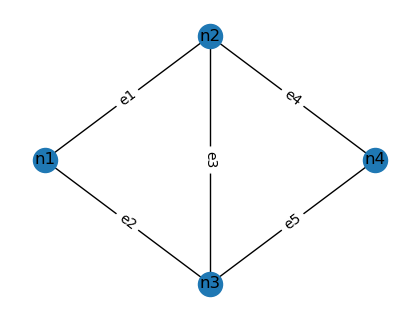

In [82]:
%matplotlib inline
plt.figure(figsize=(4,3))
# Draw network
G = nx.Graph()
for node in nodes:
    G.add_node(node, pos=nodes[node])
for e, pair in edges.items():
    G.add_edge(*pair, label=e)

pos = nx.get_node_attributes(G, 'pos')
edge_labels=nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [83]:
# Check the system function
comps_st = {'e1': 2, 'e2': 2, 'e3': 2, 'e4': 2, 'e5': 2}
f_val, sys_st, min_comps_st = sys_fun(comps_st)
print(f_val, sys_st, min_comps_st)

comps_st = {'e1': 0, 'e2': 2, 'e3': 2, 'e4': 2, 'e5': 2}
f_val, sys_st, min_comps_st = sys_fun(comps_st)
print(f_val, sys_st, min_comps_st)

comps_st = {'e1': 0, 'e2': 0, 'e3': 2, 'e4': 2, 'e5': 2}
f_val, sys_st, min_comps_st = sys_fun(comps_st)
print(f_val, sys_st, min_comps_st)

1 s {'e1': 1, 'e4': 1}
1 s {'e2': 1, 'e5': 1}
0 f None


## Multi-state BRC algorithm

### Carrying over failure rules

In [84]:
brs, rules, sys_res, monitor = {}, {}, {}, {}
rules_old = {'s': [], 'f': []} # failure rules are carried over
for i, val in enumerate(varis['sys'].values): 
    if i > 0: # do not analyse the worst state (as the worst is a failure event of the second worst state.)
        sys_fun_ = lambda comps_st : max_flow(comps_st, val, od_pair, edges, varis)
        brs_, rules_, sys_res_, monitor_ = brc.run({e: varis[e] for e in edges}, probs, sys_fun_, max_sf=np.inf, max_nb=np.inf, pf_bnd_wr=0.0, rules=rules_old)
        brs[i], rules[i], sys_res[i], monitor[i] = brs_, rules_, sys_res_, monitor_
        
        rules_old = {'s': [], 'f': rules_['f']}
    

*** Analysis completed with f_sys runs 8: out_flag = complete ***
The # of found non-dominated rules (f, s): 8 (4, 4)
Probability of branchs (f, s, u): (2.2363e-03, 9.98e-01, 1.1102e-16)
The # of branches (f, s, u), (min, avg) len of rf: 10 (5, 5, 0), (2, 2.50)
*** Analysis completed with f_sys runs 19: out_flag = complete ***
The # of found non-dominated rules (f, s): 19 (10, 9)
Probability of branchs (f, s, u): (9.9066e-03, 9.90e-01, 2.2204e-16)
The # of branches (f, s, u), (min, avg) len of rf: 28 (15, 13, 0), (2, 2.60)
*** Analysis completed with f_sys runs 12: out_flag = complete ***
The # of found non-dominated rules (f, s): 12 (8, 4)
Probability of branchs (f, s, u): (1.2145e-01, 8.79e-01, -1.1102e-16)
The # of branches (f, s, u), (min, avg) len of rf: 17 (12, 5, 0), (1, 1.75)
*** Analysis completed with f_sys runs 5: out_flag = complete ***
The # of found non-dominated rules (f, s): 5 (4, 1)
Probability of branchs (f, s, u): (2.9399e-01, 7.06e-01, 0.0000e+00)
The # of branches 

### Vanilla for comparison

In [85]:
brs_c, rules_c, sys_res_c, monitor_c = {}, {}, {}, {} # c stands for comparison

for i, val in enumerate(varis['sys'].values): 
    if i > 0: # do not analyse the worst state (as the worst is a failure event of the second worst state.)
        sys_fun_ = lambda comps_st : max_flow(comps_st, val, od_pair, edges, varis)
        brs_, rules_, sys_res_, monitor_ = brc.run({e: varis[e] for e in edges}, probs, sys_fun_, max_sf=np.inf, max_nb=np.inf, pf_bnd_wr=0.0)
        brs_c[i], rules_c[i], sys_res_c[i], monitor_c[i] = brs_, rules_, sys_res_, monitor_
        

*** Analysis completed with f_sys runs 8: out_flag = complete ***
The # of found non-dominated rules (f, s): 8 (4, 4)
Probability of branchs (f, s, u): (2.2363e-03, 9.98e-01, 1.1102e-16)
The # of branches (f, s, u), (min, avg) len of rf: 10 (5, 5, 0), (2, 2.50)
*** Analysis completed with f_sys runs 19: out_flag = complete ***
The # of found non-dominated rules (f, s): 19 (10, 9)
Probability of branchs (f, s, u): (9.9066e-03, 9.90e-01, 2.2204e-16)
The # of branches (f, s, u), (min, avg) len of rf: 28 (15, 13, 0), (2, 2.60)
*** Analysis completed with f_sys runs 12: out_flag = complete ***
The # of found non-dominated rules (f, s): 12 (8, 4)
Probability of branchs (f, s, u): (1.2145e-01, 8.79e-01, -1.1102e-16)
The # of branches (f, s, u), (min, avg) len of rf: 17 (12, 5, 0), (1, 1.75)
*** Analysis completed with f_sys runs 5: out_flag = complete ***
The # of found non-dominated rules (f, s): 5 (4, 1)
Probability of branchs (f, s, u): (2.9399e-01, 7.06e-01, 0.0000e+00)
The # of branches 

## BRC results

In [86]:
print( f"Number of total existing events: {3**len(edges)} \n" )

print('When failure rules are carried over..')
print( f"Number of total system analyses: {[k['no_sf'][-1] for m, k in monitor.items()]}")
print( f"Number of total system analyses: {sum(k['no_sf'][-1] for m, k in monitor.items())}" )


Number of total existing events: 243 

When failure rules are carried over..
Number of total system analyses: [8, 19, 12, 5]
Number of total system analyses: 44


In [87]:
print('When not..')
print( f"Number of total system analyses: {[k['no_sf'][-1] for m, k in monitor_c.items()]}")
print( f"Number of total system analyses: {sum(k['no_sf'][-1] for m, k in monitor_c.items())}" )

When not..
Number of total system analyses: [8, 19, 12, 5]
Number of total system analyses: 44


# Conclusions

Carrying over failure rules does not have any impact, although some impacts are expected for cases of larger networks.
This is because failure rules for preceding states are not minimal, so eventually they need to be reassessed. 

Still, as the computational cost is linear in the number of system states, this should not be troublesome.
